# Address Similarity Analysis Using TF-IDF Vectorization and Cosine Similarity

## Introduction
In this notebook, we demonstrate how to use TF-IDF vectorization and cosine similarity to identify the original forms of shortened addresses. This approach is useful in scenarios where addresses may have been truncated or altered or there is misspelling, and we need to find their closest matches from a reference dataset.

### Colab-Specific Setup

This block of code is designed specifically for running the notebook in Google Colab. It checks if the environment is Colab, and if so, it performs the following actions:

1. **Navigates to the Root Directory**: Ensures the starting directory is `/content`, the root directory in Colab.
2. **Clones the GitHub Repository**: If the repository does not already exist in the Colab environment, it is cloned from GitHub.
3. **Sets the Working Directory**: Changes the working directory to the cloned repository's directory, ensuring that all relative file paths in the code will work as expected.

If the notebook is not running in Google Colab, this block of code is skipped, allowing the code to be executed locally without any issues.

In [ ]:
import os

# Check if the code is running in Google Colab
def in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Run Colab-specific setup code only if in Colab
if in_colab():
    # Ensure starting at the root directory
    %cd /content

    # Define the repository name
    repo_name = 'address-similarity-analysis'

    # Check if the directory already exists
    if not os.path.exists(repo_name):
        !git clone https://github.com/aleereza/address-similarity-analysis.git
        print("Repository cloned in google colab")
    else:
        print("Repository already exists in google colab")

    %cd address-similarity-analysis/notebooks

    print("Current working directory:", os.getcwd())
else:
    print("Not running in Google Colab. Skipping Colab-specific setup.")

Not running in Google Colab. Skipping Colab-specific setup.


## Data Loading
We start by loading the original and modified addresses from JSON files.

In [ ]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the original and modified addresses
with open('../data/original_all_addresses.json', 'r') as file:
    all_addresses = json.load(file)

with open('../data/modified_all_addresses.json', 'r') as file:
    modified_addresses = json.load(file)

# Convert the list of addresses to DataFrame
df_all_addresses = pd.DataFrame(all_addresses, columns=['address'])
df_modified_addresses = pd.DataFrame(modified_addresses, columns=['address'])

# Number of addresses
print(f"There are {len(df_all_addresses)} addresses in this dataset" )

There are 3220 addresses in this dataset


## TF-IDF Vectorization
TF-IDF (Term Frequency-Inverse Document Frequency) vectorization converts text data into numerical representations. Each address is transformed into a vector that reflects the importance of each word in the context of the entire dataset.

### Term Frequency (TF)

Term Frequency measures how frequently a term appears in a document. In our case, it measures how often a word appears in an address. To do this, we need to take two steps:

1. **Fit**: This step involves learning the vocabulary of all tokens (words) in the raw text documents. The vocabulary is a set of all distinct words in the corpus. In this case, the `fit` method looks at the entire list of addresses and identifies all the unique words.

2. **Transform**: This step transforms the text documents into a term frequency matrix. Each row in this matrix represents a document (an address), and each column represents a token (word) from the vocabulary. The values in the matrix are the counts of the tokens in each address. The result is typically a sparse matrix where most of the elements are zero. This is because most addresses will not contain most of the words.

The `fit_transform` method of `CountVectorizer` is a combined function that performs both the `fit` and `transform` functions and returns the term frequency matrix.

Let's first try it on a small number of addresses for a better understanding of the result:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def display_sample_term_frequency_matrix(df, n_samples):

    top_addresses = df['address'].head(n_samples).tolist()

    # Initialize the Count Vectorizer
    count_vectorizer = CountVectorizer()

    # Fit and transform the addresses to get the term frequencies
    term_frequencies = count_vectorizer.fit_transform(top_addresses)
    tf_df = pd.DataFrame(term_frequencies.toarray(), columns=count_vectorizer.get_feature_names_out())

    # Add the address column to the DataFrame for better readability
    tf_df.insert(0, 'address', top_addresses)
    print(tf_df)

display_sample_term_frequency_matrix(df_all_addresses, 5)

                   address  150  1745  2721  560  6007  applegate  avenue  \
0  1745 T Street Southeast    0     1     0    0     0          0       0   
1      6007 Applegate Lane    0     0     0    0     1          1       0   
2       560 Penstock Drive    0     0     0    1     0          0       0   
3        150 Carter Street    1     0     0    0     0          0       0   
4      2721 Lindsay Avenue    0     0     1    0     0          0       1   

   carter  drive  lane  lindsay  penstock  southeast  street  
0       0      0     0        0         0          1       1  
1       0      0     1        0         0          0       0  
2       0      1     0        0         1          0       0  
3       1      0     0        0         0          0       1  
4       0      0     0        1         0          0       0  


Now lets apply that to the entire list of addresses:

In [ ]:
# Initialize the Count Vectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the addresses to get the term frequencies
term_frequencies = count_vectorizer.fit_transform(df_all_addresses['address'])

# Create a DataFrame to display the term frequencies
# Each row is an address and each column is a unique word from all addresses and the value is the count of that word in that address
tf_df = pd.DataFrame(term_frequencies.toarray(), columns=count_vectorizer.get_feature_names_out())

print(f"Term frequesncies matrix shape: {tf_df.shape}")

Term frequesncies matrix shape: (3220, 4389)


### Inverse Document Frequency (IDF)

Inverse Document Frequency measures the importance of a term in the entire corpus. It reduces the weight of common terms and increases the weight of rare terms. Let's calculate the IDF for the terms in our address data.

In [ ]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

# Fit the vectorizer to the address data
tfidf_vectorizer.fit(df_all_addresses['address'])

# Get the IDF values for each term
idf_values = tfidf_vectorizer.idf_

# Create a DataFrame to display the IDF values
idf_df = pd.DataFrame({'Term': tfidf_vectorizer.get_feature_names_out(), 'IDF': idf_values})

print("top most common words (Low IDF value):")
print(idf_df.sort_values(by='IDF', ascending=True).head(10))
print("top least common words (High IDF value):")
print(idf_df.sort_values(by='IDF', ascending=False).head(10))

top most common words (Low IDF value):
           Term       IDF
4101     street  2.395339
2910      drive  2.742393
2431     avenue  2.819780
3905       road  2.988402
4296       west  3.357135
3673      north  3.809589
3394       lane  3.895664
2798      court  3.924156
3680  northwest  4.179607
2927       east  4.202250
top least common words (High IDF value):
         Term     IDF
2194     8726  8.3843
3720  pafford  8.3843
2211     8848  8.3843
2212     8852  8.3843
2213     8886  8.3843
2214     88th  8.3843
3721  palermo  8.3843
2216      890  8.3843
2217     8915  8.3843
2218     8934  8.3843


### Combining TF and IDF to Get TF-IDF

TF-IDF is calculated by multiplying the Term Frequency (TF) of a term by its Inverse Document Frequency (IDF). This gives us a measure of the importance of a term in a specific document (address in this case) relative to the entire corpus. Let's calculate the TF-IDF values for a small sample of address data.

In [ ]:
# Transform the addresses to get the TF-IDF values
tfidf_matrix = tfidf_vectorizer.transform(df_all_addresses['address'])

# Create a DataFrame to display the TF-IDF values
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()

,10,100,10001,1001,1002,1004,1007,1008,101,1010,...,yerxa,yosemite,young,youngs,yucca,yule,zelda,zenith,zephyr,zion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


as expected it is mostly zero. to have a better undrestanding of the efidf matrix, lets only look at the columns that exist in the top 5 addresses. another point to consider is that The CountVectorizer and TfidfVectorizer classes in scikit-learn have default parameters that ignore terms with a length of one character. This is done to remove common stopwords and single-character tokens that are not useful for analysis:

In [ ]:
# Add the address column to the DataFrame for better readability
tfidf_df.insert(0, 'address', df_all_addresses['address'])

# Get the top 5 addresses
top_5_addresses = df_all_addresses['address'].head(5)

# Get the TF-IDF values for the top 5 addresses
top_5_tfidf_matrix = tfidf_vectorizer.transform(top_5_addresses)
top_5_tfidf_df = pd.DataFrame(top_5_tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Get the terms that exist in the top 5 addresses
non_zero_columns = top_5_tfidf_df.loc[:, (top_5_tfidf_df != 0).any(axis=0)].columns

# Filter the original TF-IDF DataFrame to include only these columns
filtered_tfidf_df = tfidf_df[['address'] + list(non_zero_columns)]

# Display the filtered DataFrame
print(filtered_tfidf_df.head())


                   address       150      1745      2721       560      6007  \
0  1745 T Street Southeast  0.000000  0.826431  0.000000  0.000000  0.000000   
1      6007 Applegate Lane  0.000000  0.000000  0.000000  0.000000  0.653357   
2       560 Penstock Drive  0.000000  0.000000  0.000000  0.688921  0.000000   
3        150 Carter Street  0.650487  0.000000  0.000000  0.000000  0.000000   
4      2721 Lindsay Avenue  0.000000  0.000000  0.687922  0.000000  0.000000   

   applegate   avenue    carter     drive      lane   lindsay  penstock  \
0   0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.686559  0.00000  0.000000  0.000000  0.319001  0.000000  0.000000   
2   0.000000  0.00000  0.000000  0.225337  0.000000  0.000000  0.688921   
3   0.000000  0.00000  0.730298  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.23136  0.000000  0.000000  0.000000  0.687922  0.000000   

   southeast    street  
0   0.511141  0.236106  
1   0.000000  0.00

### Visualizing TF-IDF Values

To better understand the importance of different terms in our address data, we can visualize the TF-IDF values. Here you can plot the TF-IDF scores for any address index.


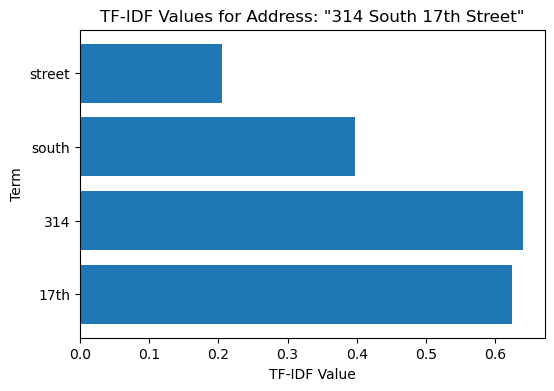

In [ ]:
import matplotlib.pyplot as plt

# Select a sample address to visualize its TF-IDF values
sample_address_index = 15
sample_address = df_all_addresses['address'].iloc[sample_address_index]
sample_tfidf_values = tfidf_matrix[sample_address_index].toarray().flatten()

# Create a DataFrame for the sample TF-IDF values
sample_tfidf_df = pd.DataFrame({'Term': tfidf_vectorizer.get_feature_names_out(), 'TF-IDF': sample_tfidf_values})
sample_tfidf_df = sample_tfidf_df[sample_tfidf_df['TF-IDF'] > 0]  # Filter out zero TF-IDF values

# Plot the TF-IDF values
plt.figure(figsize=(6, 4))
plt.barh(sample_tfidf_df['Term'], sample_tfidf_df['TF-IDF'])
plt.xlabel('TF-IDF Value')
plt.ylabel('Term')
plt.title(f'TF-IDF Values for Address: "{sample_address}"')
plt.show()


### Applying TF-IDF Vectorization to Address Data

Once we have a detailed understanding of TF-IDF, we can apply this technique to our address data. The purpose of the previous TF-IDF code was to explain how the method works under the hood. For obtaining the results, the few lines of code below are sufficient to calculate the TF-IDF matrix for both the original addresses (training set) and the modified addresses (test set). The following steps illustrate how we initialize the TF-IDF Vectorizer, fit it to our original addresses, and transform both the original and modified addresses into TF-IDF matrices.

1. **Initialize the TF-IDF Vectorizer**:
   - We start by creating an instance of `TfidfVectorizer`. This object will be used to convert our text data into TF-IDF features.

2. **Fit and Transform the Original Addresses**:
   - The `fit_transform` method is applied to the original addresses (`df_all_addresses['address']`). This step will directly give us the TF-IDF matrix for the original address data.

3. **Transform the Modified Addresses**:
   - Using the already fitted vectorizer, we transform the modified addresses (`df_modified_addresses['address']`). This step uses the learned vocabulary and IDF to convert the modified addresses into a TF-IDF matrix. It is important to note that we don't fit the vectorizer on the modified addresses. In other words, we are not calculating the importance value of those terms that only exist in the modified version (test set) and consider it as zero. A TF-IDF value of zero means that the term does not contribute to the document vector in the transformed space. This neutrality ensures that new terms do not introduce any bias or noise into the similarity calculation. Essentially, the similarity is calculated based only on the shared vocabulary learned from the original data.

By performing these steps, we convert our textual address data into numerical TF-IDF representations. These representations can then be used for further analysis, such as comparing the similarity between original and modified addresses using cosine similarity.



In [ ]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the addresses with TF-IDF Vectorizer
tfidf_all = vectorizer.fit_transform(df_all_addresses['address'])
tfidf_modified = vectorizer.transform(df_modified_addresses['address'])
print(f"tfidf_all matrix shape: {tfidf_all.shape}")
print(f"tfidf_modified matrix shape: {tfidf_modified.shape}")

tfidf_all matrix shape: (3220, 4389)
tfidf_modified matrix shape: (3220, 4389)


### Cosine Similarity

Cosine similarity is a metric used to determine how similar two documents are, regardless of their size. It calculates the cosine of the angle between two vectors, which in our case, are the TF-IDF representations of the addresses. Here’s how it works:

1. **Cosine Similarity Calculation**:
   - Cosine similarity is calculated by dividing the dot product of the vectors by the product of their magnitudes. This results in a value between -1 and 1.
   - **Value of 1**: This indicates that the vectors are identical in direction, meaning the documents (addresses) are very similar.
   - **Value of 0**: This indicates that the vectors are orthogonal, meaning the documents have no terms in common and are completely different.
   - **Value of -1**: This indicates that the vectors are diametrically opposed, meaning they are completely dissimilar.

2. **Dot Product**:
   - The dot product of two vectors is the sum of the products of their corresponding elements. For example, for vectors A and B, the dot product is the sum of the products of their corresponding values.

3. **Magnitude**:
   - The magnitude (or length) of a vector is calculated as the square root of the sum of the squares of its elements. This gives a measure of the vector's length in multidimensional space.

The `cosine_similarity(tfidf_modified, tfidf_all)` function in scikit-learn calculates the cosine similarity between each pair of vectors in the input matrices. The result of `cosine_similarity(tfidf_modified, tfidf_all)` is a matrix where each element (i, j) represents the cosine similarity between the i-th vector in tfidf_modified and the j-th vector in tfidf_all.

Cosine similarity is particularly useful for text analysis because it is invariant to the length of the documents. This means that it focuses on the orientation (direction) of the vectors rather than their magnitude, making it ideal for comparing documents of different lengths.

By using cosine similarity, we can measure how similar the modified addresses are to the original addresses based on their TF-IDF representations. This helps in identifying the most similar original address for each modified address, providing insights into how the addresses have changed.

In [ ]:
# Calculate cosine similarity between the shortened and original addresses
cosine_similarities = cosine_similarity(tfidf_modified, tfidf_all)
print(f"Cosine Similarities Matrix shape: {cosine_similarities.shape}")
print(f"Cosine Similarities Matrix type: {type(cosine_similarities)}")

Cosine Similarities Matrix shape: (3220, 3220)
Cosine Similarities Matrix type: <class 'numpy.ndarray'>


## Matching Modified Addresses to Original Addresses
We define a function to find the most similar original address for each modified address based on the highest cosine similarity. This function returns a list where each element is the original address most similar to the corresponding modified address."

In [ ]:
# Function to find the most similar original address for each shortened address
def find_most_similar_address(similarities, original_addresses):

    most_similar = []  # Initialize an empty list to store the most similar addresses

    # Iterate over each row in the similarities matrix
    for i in range(similarities.shape[0]):
        # Find the index of the maximum similarity score in the current row
        most_similar_idx = similarities[i].argmax()

        # Append the original address with the highest similarity score to the result list
        most_similar.append(original_addresses[most_similar_idx])

    return most_similar

# Calculate the cosine similarity matrix between the modified and original TF-IDF matrices
cosine_similarities = cosine_similarity(tfidf_modified, tfidf_all)

# Find the most similar original addresses for the modified addresses
most_similar_addresses = find_most_similar_address(cosine_similarities, df_all_addresses['address'])

### Illustrating Cosine Similarity Scores

To better understand the cosine similarity scores, let's visualize the top 3 most similar original addresses for a given modified address using the function below. This function takes an index of a modified address and calculates the cosine similarity between this modified address and all original addresses.


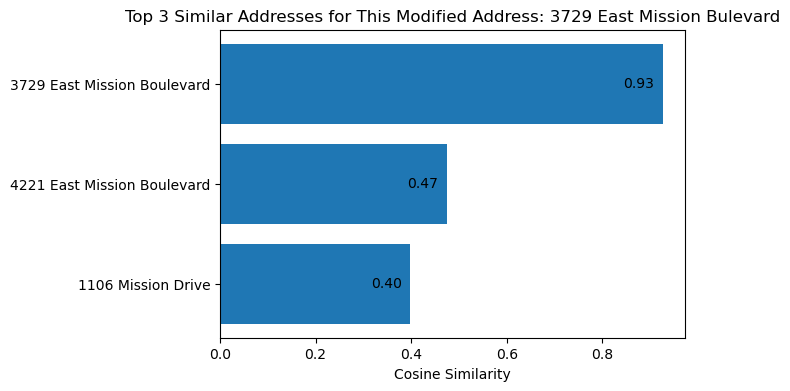

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_similar_addresses(index, similarities, original_addresses, modified_addresses):

    # Extract the similarity scores for the specified modified address
    similarity_scores = similarities[index]

    # Find the indices of the top 3 most similar original addresses
    top_indices = similarity_scores.argsort()[-3:][::-1]

    # Get the top 3 most similar original addresses and their similarity scores
    top_addresses = [original_addresses[i] for i in top_indices]
    top_scores = [similarity_scores[i] for i in top_indices]

    # Plot the bar chart
    plt.figure(figsize=(6, 4))
    bars = plt.barh(range(3), top_scores)
    plt.yticks(range(3), top_addresses)
    plt.xlabel('Cosine Similarity')
    plt.title(f'Top 3 Similar Addresses for This Modified Address: {modified_addresses[index]}')
    plt.gca().invert_yaxis()  # To display the highest similarity at the top

    # Add annotations to the bars
    for bar, score in zip(bars, top_scores):
        plt.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height() / 2,
                 f'{score:.2f}',
                 ha='center', va='center', color='black', fontsize=10)

    plt.show()

# Example usage
# Assuming cosine_similarities is the result from cosine_similarity(tfidf_modified, tfidf_all)
# and df_all_addresses['address'] is the list of original addresses

# Plot for the first modified address
plot_top_similar_addresses(21, cosine_similarities, df_all_addresses['address'], df_modified_addresses['address'])


## Results
We compare the shortened addresses with their most similar original addresses. Only those addresses that were modified (shortened) are included in the results.

In [ ]:
# Create a DataFrame to show the results
df_results = pd.DataFrame({
    'Shortened Address': df_modified_addresses['address'],
    'Most Similar Original Address': most_similar_addresses
})

# Filter out the addresses that were not changed
df_filtered_results = df_results[df_results['Shortened Address'] != df_results['Most Similar Original Address']]

df_filtered_results.to_json('../data/similar_addresses.json', orient='records', lines=True)

# Display the results
df_filtered_results.head(10)

#Todo: add an accuracy measure

,Shortened Address,Most Similar Original Address
17,5461 Wst Shades Vlley Drve,5461 West Shades Valley Drive
21,3729 East Mission Bulevard,3729 East Mission Boulevard
38,802 Madisn Stret Northwest,802 Madison Street Northwest
39,2811 Bttery Plac Northwest,2811 Battery Place Northwest
50,1508 Msschstts vn Sotheast,1508 Massachusetts Avenue Southeast
51,5615 West Vlla Maria Drive,5615 West Villa Maria Drive
52,3162 Mrtn Lthr Kng Jnr Blvrd,3162 Martin Luther King Junior Boulevard
95,7 Undrwood Place Northwest,7 Underwood Place Northwest
97,1427 Soth Carlin vn Suthst,1427 H Street
105,1608 Gales Street Northest,1608 Gales Street Northeast


### Accuracy Measurement

In this project, we manually produced the modified addresses. Therefore, we know the correct original address for each modified address because they are at the same index in the `all_addresses` and `modified_addresses` lists. This allows us to measure the accuracy of our method by calculating the percentage of found similar addresses that are actually the correct original addresses.

To measure accuracy, we compare the most similar original address found by our method to the correct original address. The accuracy is the ratio of correctly identified addresses to the total number of addresses.

The code below demonstrates how we calculate this accuracy.

In [ ]:
# Define the correct original addresses based on indices
correct_original_addresses = df_all_addresses['address'].tolist()
modified_addresses = df_modified_addresses['address'].tolist()

# Calculate accuracy by comparing found similar addresses to the correct original addresses
def calculate_accuracy_and_list_wrong_matches(found_addresses, modified_addresses, correct_addresses):
    correct_count = 0
    wrong_matches = []
    for i, (found, modified, correct) in enumerate(zip(found_addresses, modified_addresses, correct_addresses)):
        if found == correct:
            correct_count += 1
        else:
            wrong_matches.append((i, modified, found, correct))
    accuracy = correct_count / len(correct_addresses)
    return accuracy, wrong_matches

# Calculate accuracy and get wrong matches
accuracy, wrong_matches = calculate_accuracy_and_list_wrong_matches(most_similar_addresses, modified_addresses, correct_original_addresses)

# Print accuracy
print(f"Accuracy of the method: {accuracy * 100:.2f}%")

# Print wrong matches
print("\nWrong Matches (Index, Modified Address, Found Address, Correct Address):")
for match in wrong_matches:
    print(match)


Accuracy of the method: 99.07%

Wrong Matches (Index, Modified Address, Found Address, Correct Address):
(97, '1427 Soth Carlin vn Suthst', '1427 H Street', '1427 South Carolina Avenue Southeast')
(169, '201 Wst Montgomry Crss Rad', '201 West Street', '201 West Montgomery Cross Road')
(270, '416 Soth Unvrsity Bolevard', '416 Ridge Street Northwest', '416 South University Boulevard')
(345, '1309 Columba Road Nrthwest', '1309 Graniteville Road', '1309 Columbia Road Northwest')
(423, '1328 Tuckermn Strt Nrthwst', '1328 Jenks Avenue', '1328 Tuckerman Street Northwest')
(465, '1644 Nw Jrsey vnu Nrthwest', '1644 Queenstown Road', '1644 New Jersey Avenue Northwest')
(829, '2577 Rhod slnd Avne Nrthst', '2577 East Wyman Road', '2577 Rhode Island Avenue Northeast')
(906, '720 ast Mhammad Al Bulvard', '720 Southwest 2nd Street', '720 East Muhammad Ali Boulevard')
(982, '503 Blckwod Trrce Southast', '503 Orchard Road', '503 Blackwood Terrace Southeast')
(1026, '1516 Bchanan Stret Nrthwst', '1516 R

## Conclusion
For future improvements, we can explore advanced text similarity techniques to enhance the accuracy of our address matching. Implementing Levenshtein distance will help us account for minor spelling variations and typos. Using Jaccard similarity can measure the overlap between sets of words in the addresses. Combining multiple similarity measures, such as TF-IDF with cosine similarity, Levenshtein distance, and Jaccard similarity, can provide a more robust matching algorithm.

In this notebook, we demonstrated how to use TF-IDF vectorization and cosine similarity to find the most similar original addresses for shortened addresses. This method can be useful in various data cleaning and preprocessing tasks where maintaining the integrity of textual data is crucial.